In [27]:
import pandas as pd
import numpy as np
import time


dataset = pd.read_csv(r'hackathon_basketball_distribution.csv')

shotTypes = dataset.complexShotType.unique()
print(shotTypes)

ignoredShots = ['heave', 'drivingFloater', 'cutFloater', 'tip', 'lob', 'cutLayup', 'standstillLayup', 'postLeft', 'drivingLayup']
for shot in ignoredShot:
    dataset = dataset[not dataset['complexShotType'] in ]

shotIds = [i for i in range(len(shotTypes))]



dataset['complexShotType'].replace(shotTypes, shotIds, inplace=True)

['catchAndShoot' 'catchAndShootRelocating' 'stepback' 'shakeAndRaise'
 'catchAndShootOnMoveLeft' 'pullupJumper' 'overScreen'
 'catchAndShootOnMoveRight' 'heave' 'drivingFloater' 'cutFloater' 'tip'
 'lob' 'cutLayup' 'standstillLayup' 'postLeft' 'drivingLayup']


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [20]:
df1 = dataset.sample(frac=0.5, random_state=int(time.time()))
df2 = dataset.drop(df1.index)
dataset.head()


,player,season,fga3,fg3,period,startGameClock,shotClock,region,locX,locY,...,complexShotType,contestLevel,closestDefDist,rearViewContest,releaseTime,shotAngle,shooterSpeed,shooterVelAngle,rimDepth,rimLeftRight
0,"Murillo, Josue",2019,1,0,4,48.08,7.60,right wing three,-24.80,-18.64,...,0,lightly_contested,8.91,0,0.64,47.718662,0.131762,-66.153610,1.066764,-0.674009
1,"Castaneda, Urian",2019,1,1,4,37.42,1.80,right corner three,-44.74,-22.17,...,0,lightly_contested,8.34,0,0.84,97.680960,2.189780,13.513096,0.364760,0.096667
2,"Dean, Gregory",2021,1,1,2,297.60,8.36,middle three,-17.76,9.28,...,1,lightly_contested,6.96,0,1.20,-21.147858,1.133456,57.175232,1.681004,-0.661988
3,"Suazo, Garrett",2020,1,0,2,313.00,16.56,right wing three,-26.89,-20.08,...,1,uncontested,10.73,0,0.88,53.497086,2.296208,-41.983253,-0.663653,-0.857141
4,"Hatcher, Damian",2019,1,0,2,243.24,19.08,right wing three,-31.96,-22.33,...,1,uncontested,11.32,0,1.28,66.326220,1.166667,23.673782,-0.270286,0.182177


In [21]:
#feature_cols = ['startGameClock', 'shotClock', 'distance', 'dribblesBefore', 'assistOpp', 'complexShotType', 'closestDefDist', 'rearViewContest', 'shotAngle', 'shooterSpeed', 'shooterVelAngle']
feature_cols = ['startGameClock', 'shotClock', 'distance', 'dribblesBefore', 'assistOpp', 'complexShotType', 'closestDefDist', 'rearViewContest', 'shotAngle', 'shooterSpeed', 'shooterVelAngle']
X = [df1.loc[:, feature_cols], df2.loc[:, feature_cols]]

Y = [df1['fg3'], df2['fg3']]

In [22]:
from sklearn import tree

clfs = [tree.DecisionTreeClassifier(), tree.DecisionTreeClassifier()] 

for i in range(len(clfs)):
    clfs[i] = clfs[i].fit(X[i], Y[i])

    
def getPredictedAndActualMade(clfs, x1, x2):
    sum1 = 0
    sum2 = 0
    if len(x2) > 0:
        sum1 = np.sum(clfs[0].predict(x2.loc[:, feature_cols]))
    if len(x1) > 0:
        sum2 = np.sum(clfs[1].predict(x1.loc[:, feature_cols])) 
    return  sum1 + sum2, np.sum(x1['fg3']) + np.sum(x2['fg3'])

In [25]:
predictions = np.zeros((2, X[0].shape[0]))
for i in range(len(clfs)):
    predictions[i] = clfs[i].predict(X[(i+1)%2])
    fg3Total = np.sum(predictions[i])/predictions[i].size*100
    print("For Model " + str(i + 1) + " " + str(fg3Total) + "% of the 3 pointers were made league wide.")
    
if "Prediction" in dataset:
    dataset["Prediction"] = np.concatenate((predictions[1], predictions[0]), axis=None)
else:
    dataset.insert(4, "Prediction", np.concatenate((predictions[1], predictions[0]), axis=None))
print(np.mean(dataset["Prediction"]))
print(np.mean(dataset["fg3"]))

For Model 1 36.7484511405238% of the 3 pointers were made league wide.
For Model 2 36.914777527457055% of the 3 pointers were made league wide.
0.36831614333990426
0.3587589763446916


In [63]:
players = dataset.player.unique()
df = pd.DataFrame()
THRESHOLD = 200 # minimum predicted number of shots to be considered
base = 2
df['player_name'] = []
df['predicted_number_made'] = []
df['actual_number_made'] = []
df['percent_difference'] = []
df['fg%'] = []
df['predictedFg%'] = []
df['attempts'] = []
df['metric'] = []

def write_to_dataframe(df, name, pred, actual, percentDifficulty, fg, predictedFg, attempts):
    metric = np.cbrt(attempts)*(fg + percentDifficulty)
    return df.append({'player_name' : name, 'predicted_number_made' : 
                        pred, 'actual_number_made' : actual, 
                        'percent_difference': percentDifficulty, 
                        'fg%' :  fg, 'predictedFg%' : predictedFg, 'attempts' : attempts, 'metric': metric}, 
                       ignore_index = True)

for player in players:
    pS = [df1[df1['player'] == player], df2[df2['player'] == player]]
    attemptedShots = len(pS[0]) + len(pS[1])
    if attemptedShots > THRESHOLD:
        predicted_total, actual_total = getPredictedAndActualMade(clfs, pS[0], pS[1])
        percentDifference = (actual_total - predicted_total)/predicted_total

        fgPercent = actual_total/attemptedShots
        predictedPercent = predicted_total/attemptedShots
        
        df = write_to_dataframe(df, player, predicted_total, actual_total, percentDifference, fgPercent, predictedPercent, attemptedShots)

In [64]:
df.sort_values(by = ['metric'], ascending=False).head(50)

,player_name,predicted_number_made,actual_number_made,percent_difference,fg%,predictedFg%,attempts,metric
109,"Miramontes-Granillo, Andrew",329.0,424.0,0.288754,0.452026,0.350746,938.0,7.251422
90,"Gibb-Morgan, Richard",641.0,737.0,0.149766,0.408763,0.355519,1803.0,6.797947
31,"Pollock, Daquan",489.0,561.0,0.147239,0.398155,0.347055,1409.0,6.114308
151,"Yetemegn, Shaquille",564.0,634.0,0.124113,0.396250,0.352500,1600.0,6.086208
102,"Holliday, Tajae",529.0,595.0,0.124764,0.377778,0.335873,1575.0,5.846987
66,"Ney, Cory",319.0,375.0,0.175549,0.418527,0.356027,896.0,5.727225
82,"Johnson, Marcus",471.0,528.0,0.121019,0.388235,0.346324,1360.0,5.642191
137,"Sharp, Tayveon",365.0,414.0,0.134247,0.438095,0.386243,945.0,5.616504
101,"Cromer, Kurtis",350.0,402.0,0.148571,0.408537,0.355691,984.0,5.541208
203,"Kibozi, Mohamed",327.0,380.0,0.162080,0.396660,0.341336,958.0,5.508047


NameError: name 'invert_yticks' is not defined

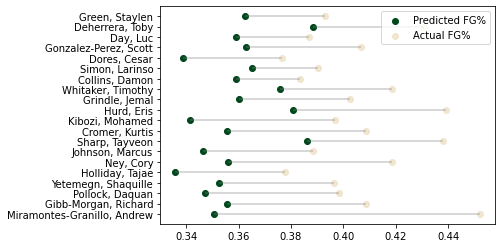

In [84]:
import matplotlib.pyplot as plt

predicted_made = df['predicted_number_made']
actual_made = df['actual_number_made']
metricplot = df['metric']

#plt.scatter(predicted_made, actual_made)

ordered_df = df.sort_values(by='metric', ascending=False).head(20)
my_range=range(1,len(ordered_df.index)+1)

plt.hlines(y=my_range, xmin=ordered_df['predictedFg%'], xmax=ordered_df['fg%'], color='grey', alpha=0.4)
plt.scatter(ordered_df['predictedFg%'], my_range, color='#00471B', alpha=1, label='Predicted FG%')
plt.scatter(ordered_df['fg%'], my_range, color='#EEE1C6', alpha=0.8 , label='Actual FG%')
plt.legend()

# Add title and axis names
plt.yticks(my_range, ordered_df['player_name'])
plt.title("Actual FG% and Predicted FG%", loc='center')
plt.xlabel('%')
plt.ylabel('Player')